In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
import re

# Data set metadata

In [27]:
ds_metadata = pd.read_csv('dataset_metadata.csv')
ds_metadata

,ds_name,nr_classes,nr_instances,nr_features,short_name
0,dna.scale,3,2000,180,dna
1,satimage.scale,6,4435,36,satimage
2,mnist.scale,10,60000,780,mnist
3,news20.scale,20,15935,62061,news20
4,letter.scale,26,15000,16,letter
5,rcv1,53,15564,47236,rcv1
6,sector.scale,105,6412,55197,sector
7,aloi.scale,1000,81000,128,aloi


In [28]:
from tabulate import tabulate
df = ds_metadata
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+----------------+--------------+----------------+---------------+--------------+
|    | ds_name        |   nr_classes |   nr_instances |   nr_features | short_name   |
|----+----------------+--------------+----------------+---------------+--------------|
|  0 | dna.scale      |            3 |           2000 |           180 | dna          |
|  1 | satimage.scale |            6 |           4435 |            36 | satimage     |
|  2 | mnist.scale    |           10 |          60000 |           780 | mnist        |
|  3 | news20.scale   |           20 |          15935 |         62061 | news20       |
|  4 | letter.scale   |           26 |          15000 |            16 | letter       |
|  5 | rcv1           |           53 |          15564 |         47236 | rcv1         |
|  6 | sector.scale   |          105 |           6412 |         55197 | sector       |
|  7 | aloi.scale     |         1000 |          81000 |           128 | aloi         |
+----+----------------+--------------+-----

# Plot optimization trajectories

In [29]:
def get_exp_name(ds, reg):
    return ds+'_'+ str(int(math.log2(reg)))

def get_save_name(ds, reg):
    i = (ds_metadata["ds_name"] == ds).idxmax()
    sname = ds_metadata["short_name"][i]
    return sname +'_'+ str(int(math.log2(reg)))

def get_plot_title(ds,reg):
    i = (ds_metadata["ds_name"] == ds).idxmax()
    sname = ds_metadata["short_name"][i]
    return sname +', k = ' + str(ds_metadata["nr_classes"][i]) +', C = 2e' + str(int(math.log2(reg))) 

def get_results(FILENAME):
    from numpy import genfromtxt
    result_np = genfromtxt(FILENAME, delimiter=',')

    df = pd.DataFrame(result_np, columns = ['time', 'sum of dual vars', 'norm/2', 'C*hinge risk', 'primal obj'])

    df['time'] = df['time']/1000 # convert from milliseconds to seconds
    df['dual obj'] = df['sum of dual vars'] - df['norm/2'] # add the column for the dual obj
    df['duality gap'] = df['primal obj'] - df['dual obj']
    return df

def get_time_conv(df,decay_factor):
    convergence_status = (df['duality gap'] <= decay_factor*df['duality gap'][0])
    if any(convergence_status):
        idx_conv = convergence_status.idxmax()
        return df['time'][idx_conv]
    else:
        return float('NaN')
    
def get_accuracy(FILENAME):
    f = open(FILENAME,'r')
    return float(re.findall(r"[-+]?\d*\.\d+|\d+", f.readline())[0])    

In [30]:
def plot_optim_traj(ds,reg):
    exp_name = get_exp_name(ds,reg)
    df_ours = get_results("../results/Ours/"+exp_name+".csv")
    df_shark = get_results("../results/Shark/"+exp_name+".csv")

    fig, ax = plt.subplots(figsize=(6.75,3.5))


    ax.semilogx(df_ours['time'],\
                df_ours['primal obj'],\
                linestyle='-', \
                color='k')
    ax.semilogx(df_ours['time'], \
                df_ours['dual obj'], \
                linestyle='--', \
                color='k')

    orange = (0.9,0.6,0)
    ax.semilogx(df_shark['time'], \
                df_shark['primal obj'], \
                linestyle = '-.', \
                color = orange,\
                linewidth = 2)
    ax.semilogx(df_shark['time'],\
                df_shark['dual obj'],\
                linestyle = ':', \
                color = orange,\
                linewidth = 2)


    plt.xlabel("Time (sec)")
    plt.ylabel("Objective value")
    plt.title(get_plot_title(ds,reg))
    ax.legend(['Ours primal','Ours dual','Shark primal','Shark dual'])
    plt.savefig('../figures/' + get_save_name(ds,reg) +'_ob.eps',format='eps')
    
    
def plot_duality_gap(ds,reg):
    exp_name = get_exp_name(ds,reg)
    df_ours = get_results("../results/Ours/"+exp_name+".csv")
    df_shark = get_results("../results/Shark/"+exp_name+".csv")
    fig, ax = plt.subplots(figsize=(6.75,3.5))

    ax.loglog(df_ours['time'],\
                df_ours['duality gap'],\
                linestyle='-', \
                color='k')

    orange = (0.9,0.6,0)
    ax.loglog(df_shark['time'],\
                df_shark['duality gap'],\
                linestyle = '-.', \
                color = orange,\
                linewidth = 2)

    plt.xlabel("Time (sec)")
    plt.ylabel("Dual gap")
    plt.title(get_plot_title(ds,reg))
    ax.legend(['Ours','Shark'])
    plt.savefig('../figures/' + get_save_name(ds,reg) +'_dg.eps',format='eps')
    

def plot_both(ds,reg):
    exp_name = get_exp_name(ds,reg)
    df_ours = get_results("../results/Ours/"+exp_name+".csv")
    df_shark = get_results("../results/Shark/"+exp_name+".csv")
    
    fig, axes = plt.subplots(1,2,figsize=(7,3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=.25,top=0.9)
    fig.suptitle(get_plot_title(ds,reg) +"\n")
    ax = axes[0]
    
    ax.semilogx(df_ours['time'],\
                df_ours['primal obj'],\
                linestyle='-', \
                color='k')
    ax.semilogx(df_ours['time'], \
                df_ours['dual obj'], \
                linestyle='--', \
                color='k')

    orange = (0.9,0.6,0)
    ax.semilogx(df_shark['time'], \
                df_shark['primal obj'], \
                linestyle = '-.', \
                color = orange,\
                linewidth = 2)
    ax.semilogx(df_shark['time'],\
                df_shark['dual obj'],\
                linestyle = ':', \
                color = orange,\
                linewidth = 2)


    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Objective value")
#     plt.title(get_plot_title(ds))
    ax.legend(['Walrus pr.','Walrus du.','Shark pr.','Shark du.'])

    ax = axes[1]
    ax.loglog(df_ours['time'],\
                df_ours['duality gap'],\
                linestyle='-', \
                color='k')

    orange = (0.9,0.6,0)
    ax.loglog(df_shark['time'],\
                df_shark['duality gap'],\
                linestyle = '-.', \
                color = orange,\
                linewidth = 2)

    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Duality gap")
#     plt.title(get_plot_title(ds))
    ax.legend(['Walrus','Shark'])
    plt.savefig('../figures/' + get_save_name(ds,reg) +'_both.eps',format='eps',bbox_inches = "tight")

## Satimage

In [31]:
ds = ds_metadata['ds_name'][1]
reg = float(2**0) # in Dogan et al 2016, they chose C = 2**0
get_exp_name(ds,reg)

'satimage.scale_0'

In [32]:
# plot_optim_traj(ds,reg)

In [33]:
# plot_duality_gap(ds,reg)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


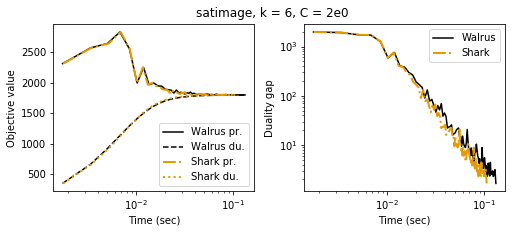

In [34]:
plot_both(ds,reg)

In [35]:
ds_metadata

,ds_name,nr_classes,nr_instances,nr_features,short_name
0,dna.scale,3,2000,180,dna
1,satimage.scale,6,4435,36,satimage
2,mnist.scale,10,60000,780,mnist
3,news20.scale,20,15935,62061,news20
4,letter.scale,26,15000,16,letter
5,rcv1,53,15564,47236,rcv1
6,sector.scale,105,6412,55197,sector
7,aloi.scale,1000,81000,128,aloi


In [36]:
ds_metadata

,ds_name,nr_classes,nr_instances,nr_features,short_name
0,dna.scale,3,2000,180,dna
1,satimage.scale,6,4435,36,satimage
2,mnist.scale,10,60000,780,mnist
3,news20.scale,20,15935,62061,news20
4,letter.scale,26,15000,16,letter
5,rcv1,53,15564,47236,rcv1
6,sector.scale,105,6412,55197,sector
7,aloi.scale,1000,81000,128,aloi


## Sector

In [37]:
ds = ds_metadata['ds_name'][6]
reg = float(2**-1) # Dogan's regularizer is -1
get_exp_name(ds,reg)

'sector.scale_-1'

In [38]:
# plot_optim_traj(ds,reg)

In [39]:
# plot_duality_gap(ds,reg)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


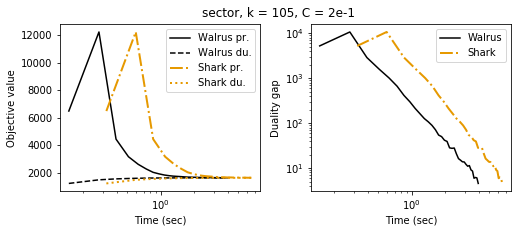

In [40]:
plot_both(ds,reg)

# Dual gap after a single outer iteration

In [41]:
ds_metadata

,ds_name,nr_classes,nr_instances,nr_features,short_name
0,dna.scale,3,2000,180,dna
1,satimage.scale,6,4435,36,satimage
2,mnist.scale,10,60000,780,mnist
3,news20.scale,20,15935,62061,news20
4,letter.scale,26,15000,16,letter
5,rcv1,53,15564,47236,rcv1
6,sector.scale,105,6412,55197,sector
7,aloi.scale,1000,81000,128,aloi


In [42]:
datasets = range(8)
hyperparameters = [2**(i-6) for i in range(10)]

In [43]:
df_1itr = pd.DataFrame({'ds_name':[], 
                        'ds_idx':[],
                        'short_name':[],
                        'regularizer':[],
                        'reg_str':[],
                        'decay_factor_of_dg':[]})

row_id = 0
decay_factor = 0.01

for i in datasets:
    for C in hyperparameters:
        ds = ds_metadata['ds_name'][i]
        sname = ds_metadata['short_name'][i]
        EXPNAME = get_exp_name(ds,C)
        # print(EXPNAME)
        FILENAME = "../results/Ours/" + EXPNAME + '.csv'
        df_ours = get_results(FILENAME)
        dg_ours = df_ours['duality gap'][0]

        FILENAME = "../results/Shark/" + EXPNAME + '.csv'
        df_shark = get_results(FILENAME)
        dg_shark = df_shark['duality gap'][0]
        # print(t_shark/t_ours)

        df_1itr.loc[row_id] = [ds,i,sname,C, str(int(math.log2(C))), dg_ours/dg_shark]
        row_id = row_id + 1

## the ratio of the dual gaps after a single outer iteration are essentially identical

In [44]:
max(df_1itr['decay_factor_of_dg'])

1.0000020715109257

In [45]:
min(df_1itr['decay_factor_of_dg'])

0.9999936293410219

# Get time ratios for all experiments

In [46]:
df_time = pd.DataFrame({'ds_name':[], 
                        'ds_idx':[],
                        'short_name':[],
                        'regularizer':[],
                        'reg_str':[],
                        'Walrus_time':[],
                        'Shark_time':[],
                        'ratio':[],
                        'decay_factor':[],
                        'accuracy_Ours':[],
                        'accuracy_Shark':[]})

row_id = 0
for i in datasets:
    for C in hyperparameters:
        for decay_factor in [0.1, 0.01, 0.001]:
            ds = ds_metadata['ds_name'][i]
            sname = ds_metadata['short_name'][i]
            EXPNAME = get_exp_name(ds,C)
            FILENAME = "../results/Ours/" + EXPNAME + '.csv'
            df_ours = get_results(FILENAME)
            t_ours = get_time_conv(df_ours,decay_factor)
            
            FILENAME = "../accuracies/Ours/" + EXPNAME + '.csv'
            acc_ours = get_accuracy(FILENAME)

            FILENAME = "../results/Shark/" + EXPNAME + '.csv'
            df_shark = get_results(FILENAME)
            t_shark = get_time_conv(df_shark,decay_factor)
            # print(t_shark/t_ours)
            
            FILENAME = "../accuracies/Shark/" + EXPNAME + '.csv'
            acc_shark = get_accuracy(FILENAME)

            if(np.isnan(t_shark) != np.isnan(t_ours)):
                raise SystemExit("One converged but the other didn't!")
                
            df_time.loc[row_id] = [ds,\
                                   i,\
                                   sname,\
                                   C,\
                                   str(int(math.log2(C))),\
                                   t_ours,\
                                   t_shark,\
                                   t_ours/t_shark,\
                                   str(decay_factor),\
                                  acc_ours,\
                                  acc_shark]
            row_id = row_id + 1

# df_time
df_time.to_csv("../results/speed_results.csv")

# Accuracy on datasets vs crossvalidation

In [47]:
df_acc = df_time[['short_name','reg_str', 'accuracy_Ours']]
df_acc
df_acc = df_acc.rename(columns={"short_name": "data set", "reg_str": "regularizer"})
df_acc = df_acc.pivot_table(index='data set', columns='regularizer', values='accuracy_Ours').round(2)


# .to_latex('acc_table.tex')
df_acc = df_acc[['-6','-5','-4','-3','-2','-1','0','1','2','3']]
df_acc = df_acc.reindex(['dna','satimage','mnist','news20','letter','rcv1','sector','aloi'])
df_acc.to_latex('../results/acc_table.tex')

In [48]:
df_acc

regularizer,-6,-5,-4,-3,-2,-1,0,1,2,3
data set,,,,,,,,,,
dna,94.77,94.69,95.11,94.77,93.76,93.34,92.41,92.24,92.24,92.24
satimage,82.35,82.65,83.20,83.65,83.80,84.10,84.20,84.10,84.15,84.10
mnist,92.28,92.38,92.43,92.24,92.21,92.13,92.16,91.92,91.79,91.65
news20,82.27,83.45,84.00,85.00,85.40,85.22,85.02,84.52,84.10,83.97
letter,70.04,71.28,71.70,71.66,71.48,71.30,71.26,71.30,71.02,71.22
rcv1,87.23,87.98,88.46,88.76,88.79,88.69,88.48,88.25,88.12,88.02
sector,93.20,93.39,93.64,93.92,94.01,94.04,94.04,94.01,93.95,93.83
aloi,86.17,87.01,87.99,88.66,89.04,89.46,89.64,89.70,89.69,89.51


## Color by dual gap decay ratio

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


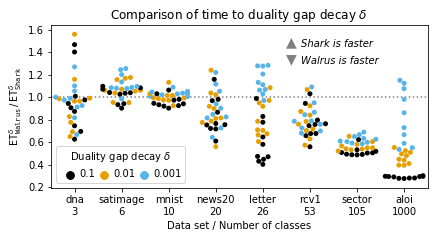

In [49]:
ds_metadata['xtick_name'] = ds_metadata['short_name'] + "\n" + ds_metadata['nr_classes'].map(str)

plt.figure(figsize=(6.75,3))


# rcParams.update({'figure.autolayout': True})



# color palette from https://stackoverflow.com/a/57157075
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", 
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

sns.set_palette(sns.color_palette(colors))

r1 = sns.swarmplot(x="short_name", y="ratio", data=df_time,\
                   hue = 'decay_factor', hue_order=["0.1","0.01","0.001"])
# ax = plt.gca()
# cs = r1.collections[0]
# cs.set_offset_position('data')
# swarm_xy_coords = cs.get_offsets()


# r1.legend(loc=(0.61,0.7),title = "Dual gap decay factor",ncol=3,handletextpad=-.1,columnspacing=-.1)
r1.legend(loc='lower left',title = "Duality gap decay $\delta$",ncol=3,handletextpad=-.1,columnspacing=-.1)

arrow_x_coord = 4.5
text_x_coord = arrow_x_coord+0.3
walrus_y_coord = 1.3
arrow_offset = 0.005
shark_y_coord = walrus_y_coord + 0.15

plt.annotate("\u25b2",xy=(arrow_x_coord,shark_y_coord + arrow_offset),fontsize=14, color ='gray')
plt.annotate("\u25bc",xy=(arrow_x_coord,walrus_y_coord + arrow_offset),fontsize=14, color='gray')

plt.annotate("Shark is faster",xy=(text_x_coord,shark_y_coord),style='italic')
plt.annotate("Walrus is faster",xy=(text_x_coord,walrus_y_coord),style ='italic',)



plt.axhline(y=1, color='gray', linestyle=':')
plt.xlabel("Data set / Number of classes")
# plt.ylabel("Ratio of ours / Shark's time")
plt.ylabel("$\mathtt{ET}^\delta_{\mathtt{Walrus}}\, /\, \mathtt{ET}^\delta_{\mathtt{Shark}}$")
plt.title("Comparison of time to duality gap decay $\delta$")

plt.xticks(range(ds_metadata.shape[0]), ds_metadata['xtick_name'])
# plt.savefig('../figures/time_comparison_' + str(int(math.log10(ratio))) + '.eps',format='eps')
plt.savefig('../figures/time_comparison.eps',format='eps',bbox_inches = "tight")

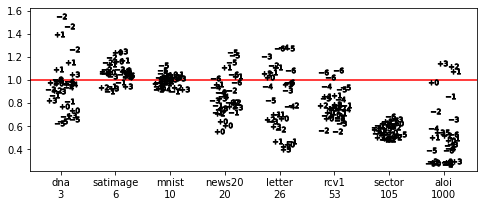

In [50]:
import random
random.random()
plt.figure(figsize=(8,3))
plt.axhline(y=1, color='r', linestyle='-')
for index, row in df_time.iterrows():
    x = row['ds_idx']
    y = row['ratio']
    mksz = 10
    if row['regularizer'] < 1:
        lab = "$-"+str(-int(row['reg_str']))+"$"
    else:
        lab = "$+"+str(int(row['reg_str']))+"$"
    plt.plot(x + (random.random()-0.5)/2, y, marker=lab, color = "black", markersize=mksz)
plt.xticks(range(ds_metadata.shape[0]), ds_metadata['xtick_name'])
plt.savefig('../figures/time_comparison_reg_markers.eps',format='eps',bbox_inches = "tight")